<a href="https://colab.research.google.com/github/tatsath/PortfolioOptimization/blob/main/DigitalOptionPrice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href="https://colab.research.google.com/github/tatsath/PortfolioOptimization/blob/main/DigitalOptionPrice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


In [65]:
import numpy as np

import seaborn as sns
import numpy.matlib
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy import stats
from scipy.stats import norm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import time
import copy


In [66]:
#Setting seed
torch.manual_seed(20)
torch.cuda.manual_seed(20)
np.random.seed(20)

In [67]:
# 1 asset 
params = {
    "S0" : np.array([100]),
    "mu" : np.array([0.03]),
    "sigma" : np.array([0.8]),
    "rho" : np.array([[1]]),
    "rf" : 0.01,
    "delta" : np.array([0.7]),
    "Strike" : np.array([100])
    }
params_Q = copy.copy(params)

In [68]:
float(params["Strike"])

100.0

In [69]:
#%% Simulation Engine for price paths
def SimPath(Ndt, params, T, Nsims):
    
    dt = T/Ndt
    
    N_assets= 1
    
    assert N_assets == params["sigma"].shape[0], "#assets in mu != #assets in sigma"
    assert N_assets == params["rho"].shape[0], "#assets in mu != #assets in rho"
    assert params["rho"].ndim == 2, "rho must be matrix"
    assert N_assets == params["rho"].shape[1], "rho not square matrix"
    
    S = np.zeros((Ndt+1, Nsims, N_assets ))
    S[0,:,:] = params["S0"]

    
    for i in range(Ndt):
        
        dW = np.sqrt(dt) * np.random.multivariate_normal(np.zeros(N_assets), params["rho"], Nsims)
        S[i+1,:,:] = S[i,:,:] * np.exp((params["mu"]-0.5*params["sigma"]**2)*dt + params["sigma"]*dW)
        
    t = np.linspace(0,T,Ndt+1)
    return t, S
        

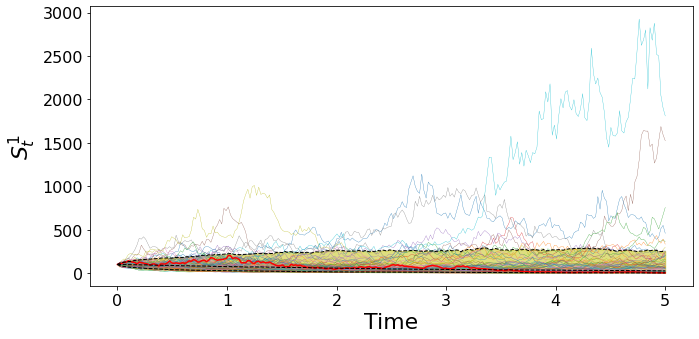

In [70]:
# Sim some paths and show sims with quantiles and a sample path
t, S = SimPath(Ndt=252, params = params, T=5, Nsims = 1000)

plt.figure(figsize=(10,5))
plt.rcParams.update({'font.size': 16})
plt.rc('axes', labelsize=22)
for i in range(S.shape[2]):
    
    plt.subplot(1,S.shape[2],i+1)
    
    plt.fill_between(t, np.quantile(S[:,:,i],0.1,axis=1).T, np.quantile(S[:,:,i],0.9,axis=1).T, color='y', alpha=0.5)
    plt.plot(t, S[:,:100,i],linewidth=0.3)
    plt.plot(t, S[:,0,i],color='r',linewidth=1.5)
    plt.plot(t, np.quantile(S[:,:,i],[0.1, 0.5, 0.9],axis=1).T,color='k',linewidth=1, linestyle='--')
    
    plt.xlabel("Time")
    plt.ylabel("$S_t^" +str(i+1)+"$")
    
plt.tight_layout()
plt.show()

In [71]:
# the ANN for policy iteration
class MyNet(nn.Module):
    
    def __init__(self, n, n_assets ):
        super(MyNet, self).__init__()

        # 2 input layer (t, X_t^delta), 1 output channel, 3 hidden layers with n units each
        self.f_in_to_h1 = nn.Linear( 2 , n)
        self.f_h1_to_h2 = nn.Linear(n, n)
        self.f_h2_to_out = nn.Linear(n, n_assets)
        self.myReLU = nn.ReLU()

    def forward(self, x):
        
        # input into 1st hidden layer
        h1 = self.myReLU(self.f_in_to_h1(x) )
        
        # 1st hidden to 2nd hidden layer
        h2 = self.myReLU(self.f_h1_to_h2(h1))
            
        # 2nd hidden layer to output layer
        y = self.f_h2_to_out(h2)      
        #y = y.clamp(-1,1)
        #y = F.logsigmoid(h2)
        
        return y

In [72]:
# from a minibatch compute the risk measure
def GetRiskMeasure(X, Type):
    #TVaR    
    if (Type == "TVaR"):
        
        alpha = 0.15
        Qtl= torch.quantile(X, alpha)
        RiskMeasure = -torch.mean(X[X<=Qtl])   
     # alpha-beta
    elif (Type == "alpha-beta" ):
        
        alpha = 0.1
        LQtl = torch.quantile(X,alpha)
        
        beta = 0.9
        UQtl = torch.quantile(X,beta)
        
        # weight factor (p in the paper)
        p = 0.75
        eta = p * alpha + (1-p) * (1-beta)
        RiskMeasure = -(p* torch.mean(X[X<=LQtl]) \
                        + (1-p) * torch.mean(X[X>=UQtl] ) )/eta        
    #Variance
    elif (Type == "Variance"):  
        RiskMeasure = torch.var(X)   
        
    return RiskMeasure

In [73]:
Ndt = 500
T =5
Nsims = 5000

In [74]:
t, S = SimPath(Ndt, params, T=T, Nsims=Nsims) 
num_asset = 1
dt = t[1]-t[0]

# don't think we need sensitivities w.r.t. this as they are fixed per simulation

S_t = torch.tensor(S, dtype=torch.float, requires_grad=False, device=device)

x=np.zeros((Ndt+1, Nsims, 2))   
x[:,:,0] = np.matlib.repmat(t.reshape(-1,1)/t[-1], 1, Nsims)

x[:,:,1] = S_t.cpu().squeeze()

xt = torch.tensor(x, dtype=torch.float, device=device)

#Get the hedges from the NN, the input is the 
delta_t = net(xt) 



RuntimeError: ignored

In [ ]:
Payoff_T = torch.zeros(Nsims, dtype=torch.float, requires_grad=False, device=device)

S_Maturity = S_t[-1,:,:].cpu().squeeze()
Hedge_Maturity = delta_t[-1,:,:].cpu().squeeze()      



In [ ]:
Hedge_Maturity.shape

In [ ]:

#Get digital payoff for each scenario-Assuming short
for i in range(len(S_Maturity)):
    if(S_Maturity[i] >= float(params["Strike"])):
        Payoff_T[i] = S_Maturity[i]-float(params["Strike"])
    else:
        Payoff_T[i] = 0 
#set_trace() 

#This is the PnL post hedge at maturity, assuming short option delta hedged, which is minimized using some convex function such as VaR or alpha beta   
PnL_T = -Payoff_T + torch.sum((delta_t[1:,:,:] * (S_t[1:,:,:]-S_t[:-1,:,:])).squeeze(), axis =0)    
    
RiskMeasure = GetRiskMeasure(PnL_T, "TVaR")   

In [ ]:
torch.sum((delta_t[1:,:,:] * (S_t[1:,:,:]-S_t[:-1,:,:])).squeeze(), axis =0) 

In [ ]:
delta_t[1:,:,:].shape

In [ ]:
#This is the PnL post hedge at maturity, assuming short option delta hedged, which is minimized using some convex function such as VaR or alpha beta   
PnL_T = -Payoff_T + torch.sum((delta_t[1:,:,:] * (S_t[1:,:,:]-S_t[:-1,:,:])).squeeze(), axis =0)    
    
RiskMeasure = GetRiskMeasure(PnL_T, "TVaR")   

In [ ]:
# given an ANN run a simulation and compute the riskmeasure for the PnL of option payoff at maturity
from IPython.core.debugger import set_trace

def SimRM(net, Ndt, T, Nsims, params, device):
      
    t, S = SimPath(Ndt, params, T=T, Nsims=Nsims) 
    num_asset = 1
    dt = t[1]-t[0]

    # don't think we need sensitivities w.r.t. this as they are fixed per simulation
    
    S_t = torch.tensor(S, dtype=torch.float, requires_grad=False, device=device)
    
    x=np.zeros((Ndt+1, Nsims, 2))   
    x[:,:,0] = np.matlib.repmat(t.reshape(-1,1)/t[-1], 1, Nsims)

    x[:,:,1] = S_t.cpu().squeeze()

    xt = torch.tensor(x, dtype=torch.float, device=device)
    
    #Get the hedges from the NN, the input is the 
    delta_t = net(xt) 
    
    Payoff_T = torch.zeros(Nsims, dtype=torch.float, requires_grad=False, device=device)

    S_Maturity = S_t[-1,:,:].cpu().squeeze()
    Hedge_Maturity = delta_t[-1,:,:].cpu().squeeze()      
    
    #Get digital payoff for each scenario-Assuming short
    for i in range(len(S_Maturity)):
        if(S_Maturity[i] >= float(params["Strike"])):
            Payoff_T[i] = (S_Maturity[i]-float(params["Strike"]))
        else:
            Payoff_T[i] = 0 

    #Payoff_T = torch.maximum(S_Maturity-torch.tensor(float(params["Strike"]), dtype=torch.float), 0)        
    #set_trace() 

    #This is the PnL post hedge at maturity, assuming short option delta hedged, which is minimized using some convex function such as VaR or alpha beta   
    PnL_T = -Payoff_T + torch.sum((delta_t[1:,:,:] * (S_t[1:,:,:]-S_t[:-1,:,:])).squeeze(), axis =0)    
       
    RiskMeasure = GetRiskMeasure(-PnL_T, "TVaR")   
   
    return Hedge_Maturity, S_Maturity, PnL_T, RiskMeasure, t

#Plot St vs Wt

In [ ]:
# plot histogram of portfolio, sample path, and show dependence of X^\pi on X^\delta
def PlotHists_Hedge(S_Maturity, Hedge_Maturity,t):
    
    Xcp = S_Maturity.clone().cpu().detach().numpy()
    Ycp = Hedge_Maturity.clone().cpu().detach().numpy()
    
    plt.figure(figsize=(15,5))

    plt.subplot(1,1,1)
    #bins = np.linspace(0,4,50)    
    # xs = [min(Xcp), max(Xcp)]
    # plt.plot(xs,xs,'--k' )
    plt.scatter(Xcp,Ycp, marker='o',color='r', s=5)
    plt.xlim(0,200)
    plt.ylim(0,10)

    plt.rcParams.update({'font.size': 16})
    plt.rc('axes', labelsize=22)

    plt.tight_layout()
    
    plt.show()

In [ ]:
# create an ANN and use GPU if available

if torch.cuda.is_available():
    device = torch.device('cuda') 
else:
    device = torch.device('cpu') 

net = MyNet(50, len(params["S0"])).to(device)

In [ ]:
Hedge_Maturity, S_Maturity, PnL_T, RiskMeasure, t = SimRM(net, Ndt=252, T=5, Nsims=10000, params=params, device=device)
    
PlotHists_Hedge(S_Maturity, Hedge_Maturity,t)

In [ ]:
torch.cuda.is_available()

In [ ]:
# train the model

optimizer = optim.Adam(net.parameters())


Nepochs = 1000
loss_hist = []
risk_history = []
wass_dist_history=[]

start_time= time.time()

for epoch in range(Nepochs):  # loop over the dataset multiple times

    
    
    # zero the parameter gradients
    optimizer.zero_grad()


    #hedge_payoff, true_payoff, S = SimHedge(net, Ndt, S0, mu, sigma, T, Nsims, True)
    Hedge_Maturity, S_Maturity, PnL_T, RiskMeasure, t = SimRM(net, Ndt=500, T=5, Nsims=10000, params=params, device=device)
    
    #loss = 100*(wass_dist)*(wass_dist>0.2) + RiskMeasure +100*(wass_dist)*(wass_dist>0.15)
    loss = RiskMeasure 
    
    loss.backward()   
    
    # optimize
    optimizer.step()
    
    # store running loss
    loss_hist.append(  loss.item() )
    risk_history.append( RiskMeasure.cpu().detach().numpy() )
    #wass_dist_history.append( wass_dist.cpu().detach().numpy() )
    
    print(".",end="")
    
    # plot output every 50 iterations
    if( (epoch % 20 == 0) and (epoch>1) ):
        
        print(epoch, end=" ")
        print("duaration = ", "{:.3f}".format(time.time() - start_time), " secs")
        start_time = time.time()        

        print("Loss:", "{:.3f}".format(loss.item()))

        PlotHists_Hedge(S_Maturity, Hedge_Maturity,t)              
    
        

print('Finished Training')